In [45]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
data = pd.read_csv('resampled_nation.csv')
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,15,2,3,1053,1,2,4,4,...,2,1,27,3,2,1,3,1,1,2
1,1,1,15,2,3,1053,1,2,4,4,...,2,1,27,3,2,1,3,1,1,2
2,0,1,20,4,0,2235,1,3,4,4,...,2,2,33,1,1,2,3,1,1,2
3,1,2,6,3,2,1050,1,1,4,3,...,1,2,35,2,2,2,4,1,2,2
4,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2


In [47]:
data.Creditability.value_counts()

1    1527
0     399
Name: Creditability, dtype: int64

In [48]:
male = data[(data['Sex & Marital Status']==1) | (data['Sex & Marital Status']==3) | (data['Sex & Marital Status']==4)]
female = data[(data['Sex & Marital Status']==2) | (data['Sex & Marital Status']==5)]

A quick and simple discrimination measure: males are slightly more often assigned good creditability in the data.

In [49]:
print('Ratio of males (n = %d) with good credit risk: %.2f' % (male.shape[0], np.sum(male.Creditability==1) / male.shape[0]))
print('Ratio of females (n = %d) with good credit risk: %.2f' % (female.shape[0], np.sum(female.Creditability==1) / female.shape[0]))

Ratio of males (n = 1497) with good credit risk: 0.82
Ratio of females (n = 429) with good credit risk: 0.69


Categorical variables should probably be one-hot encoded.

Visualize some correlations; these are most likely not the most interesting ones

In [50]:
# g=sns.pairplot(data, vars=data.columns[[2,3,5,13]], hue='Creditability')

Define two sets of features as per Laura's summary:
- legal only contains those which are clearly ok to use
- maybe contains also the legally ambiguous features

In [51]:
legal = data.columns[ [1, 3, 5, 6, 8, 10, 12, 14, 16 ] ]
maybe = data.columns[ [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17 ] ]

In [52]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier

Have a look at prediction performance;
- only cross-validation scores (using the whole dataset)at this point, no parameter tuning
- F1 score chosen somewhat arbitrarily

In [53]:
data['Credit Amount'] = np.log(data['Credit Amount'])
X = data[data.columns[1:]]
y = data['Creditability']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [54]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
results = pd.DataFrame(0, index=[m[0] for m in models], columns=['all', 'maybe', 'legal'])

In [55]:
print('Scores using all data')
for name, model in models:
    cv_res = cross_val_score(model, X, y, cv=10, scoring='f1')
    results.loc[name, 'all'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))
    

Scores using all data
RF: 0.90 (0.08)
LR: 0.87 (0.06)
DT: 0.88 (0.10)
NB: 0.85 (0.10)
SVC: 0.91 (0.05)


In [56]:
print('Scores using legal data')
for name, model in models:
    cv_res = cross_val_score(model, X[legal], y, cv=10, scoring='f1')
    results.loc[name, 'legal'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))


Scores using legal data
RF: 0.90 (0.10)
LR: 0.89 (0.03)
DT: 0.87 (0.11)
NB: 0.87 (0.04)
SVC: 0.91 (0.06)


In [57]:
print('Scores using maybe ok data')
for name, model in models:
    cv_res = cross_val_score(model, X[maybe], y, cv=10, scoring='f1')
    results.loc[name, 'maybe'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))

Scores using maybe ok data
RF: 0.90 (0.07)
LR: 0.88 (0.05)
DT: 0.87 (0.10)
NB: 0.87 (0.07)
SVC: 0.90 (0.07)


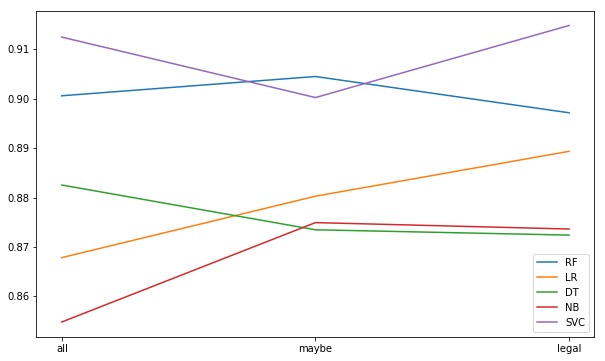

,all,maybe,legal
RF,0.900576,0.904474,0.897137
LR,0.867843,0.880268,0.889342
DT,0.882527,0.873471,0.872398
NB,0.854829,0.874925,0.873629
SVC,0.912441,0.900214,0.914795


In [58]:
plt.rcParams['figure.figsize'] = [10, 6]
# results.T.plot()
# ax = plt.gca()
xt = results.columns

for m in results.index:
    plt.plot(xt, results.loc[m], label=m)
plt.legend()
plt.show()
results

The overall trend is as expected: less features leads to worse results. NB and SVC are exceptions, but this may be randomness due to small data.